Connected to py311 (Python 3.11.6)

c:\Users\Win10\Documents\MEGA\mestrado\IM382ElementosFinitos2\im382\polynomials.py:61: RuntimeWarning: divide by zero encountered in divide
  DPn1 = (1 / b1n) * (b2n * Pn1 + b3n * Pn)
c:\Users\Win10\Documents\MEGA\mestrado\IM382ElementosFinitos2\im382\polynomials.py:61: RuntimeWarning: invalid value encountered in multiply
  DPn1 = (1 / b1n) * (b2n * Pn1 + b3n * Pn)
c:\Users\Win10\Documents\MEGA\mestrado\IM382ElementosFinitos2\im382\polynomials.py:61: RuntimeWarning: divide by zero encountered in divide
  DPn1 = (1 / b1n) * (b2n * Pn1 + b3n * Pn)
c:\Users\Win10\Documents\MEGA\mestrado\IM382ElementosFinitos2\im382\polynomials.py:61: RuntimeWarning: invalid value encountered in multiply
  DPn1 = (1 / b1n) * (b2n * Pn1 + b3n * Pn)
c:\Users\Win10\Documents\MEGA\mestrado\IM382ElementosFinitos2\im382\polynomials.py:61: RuntimeWarning: divide by zero encountered in divide
  DPn1 = (1 / b1n) * (b2n * Pn1 + b3n * Pn)
c:\Users\Win10\Documents\MEGA\mestrado\IM382ElementosFinitos2\im382\polynomial

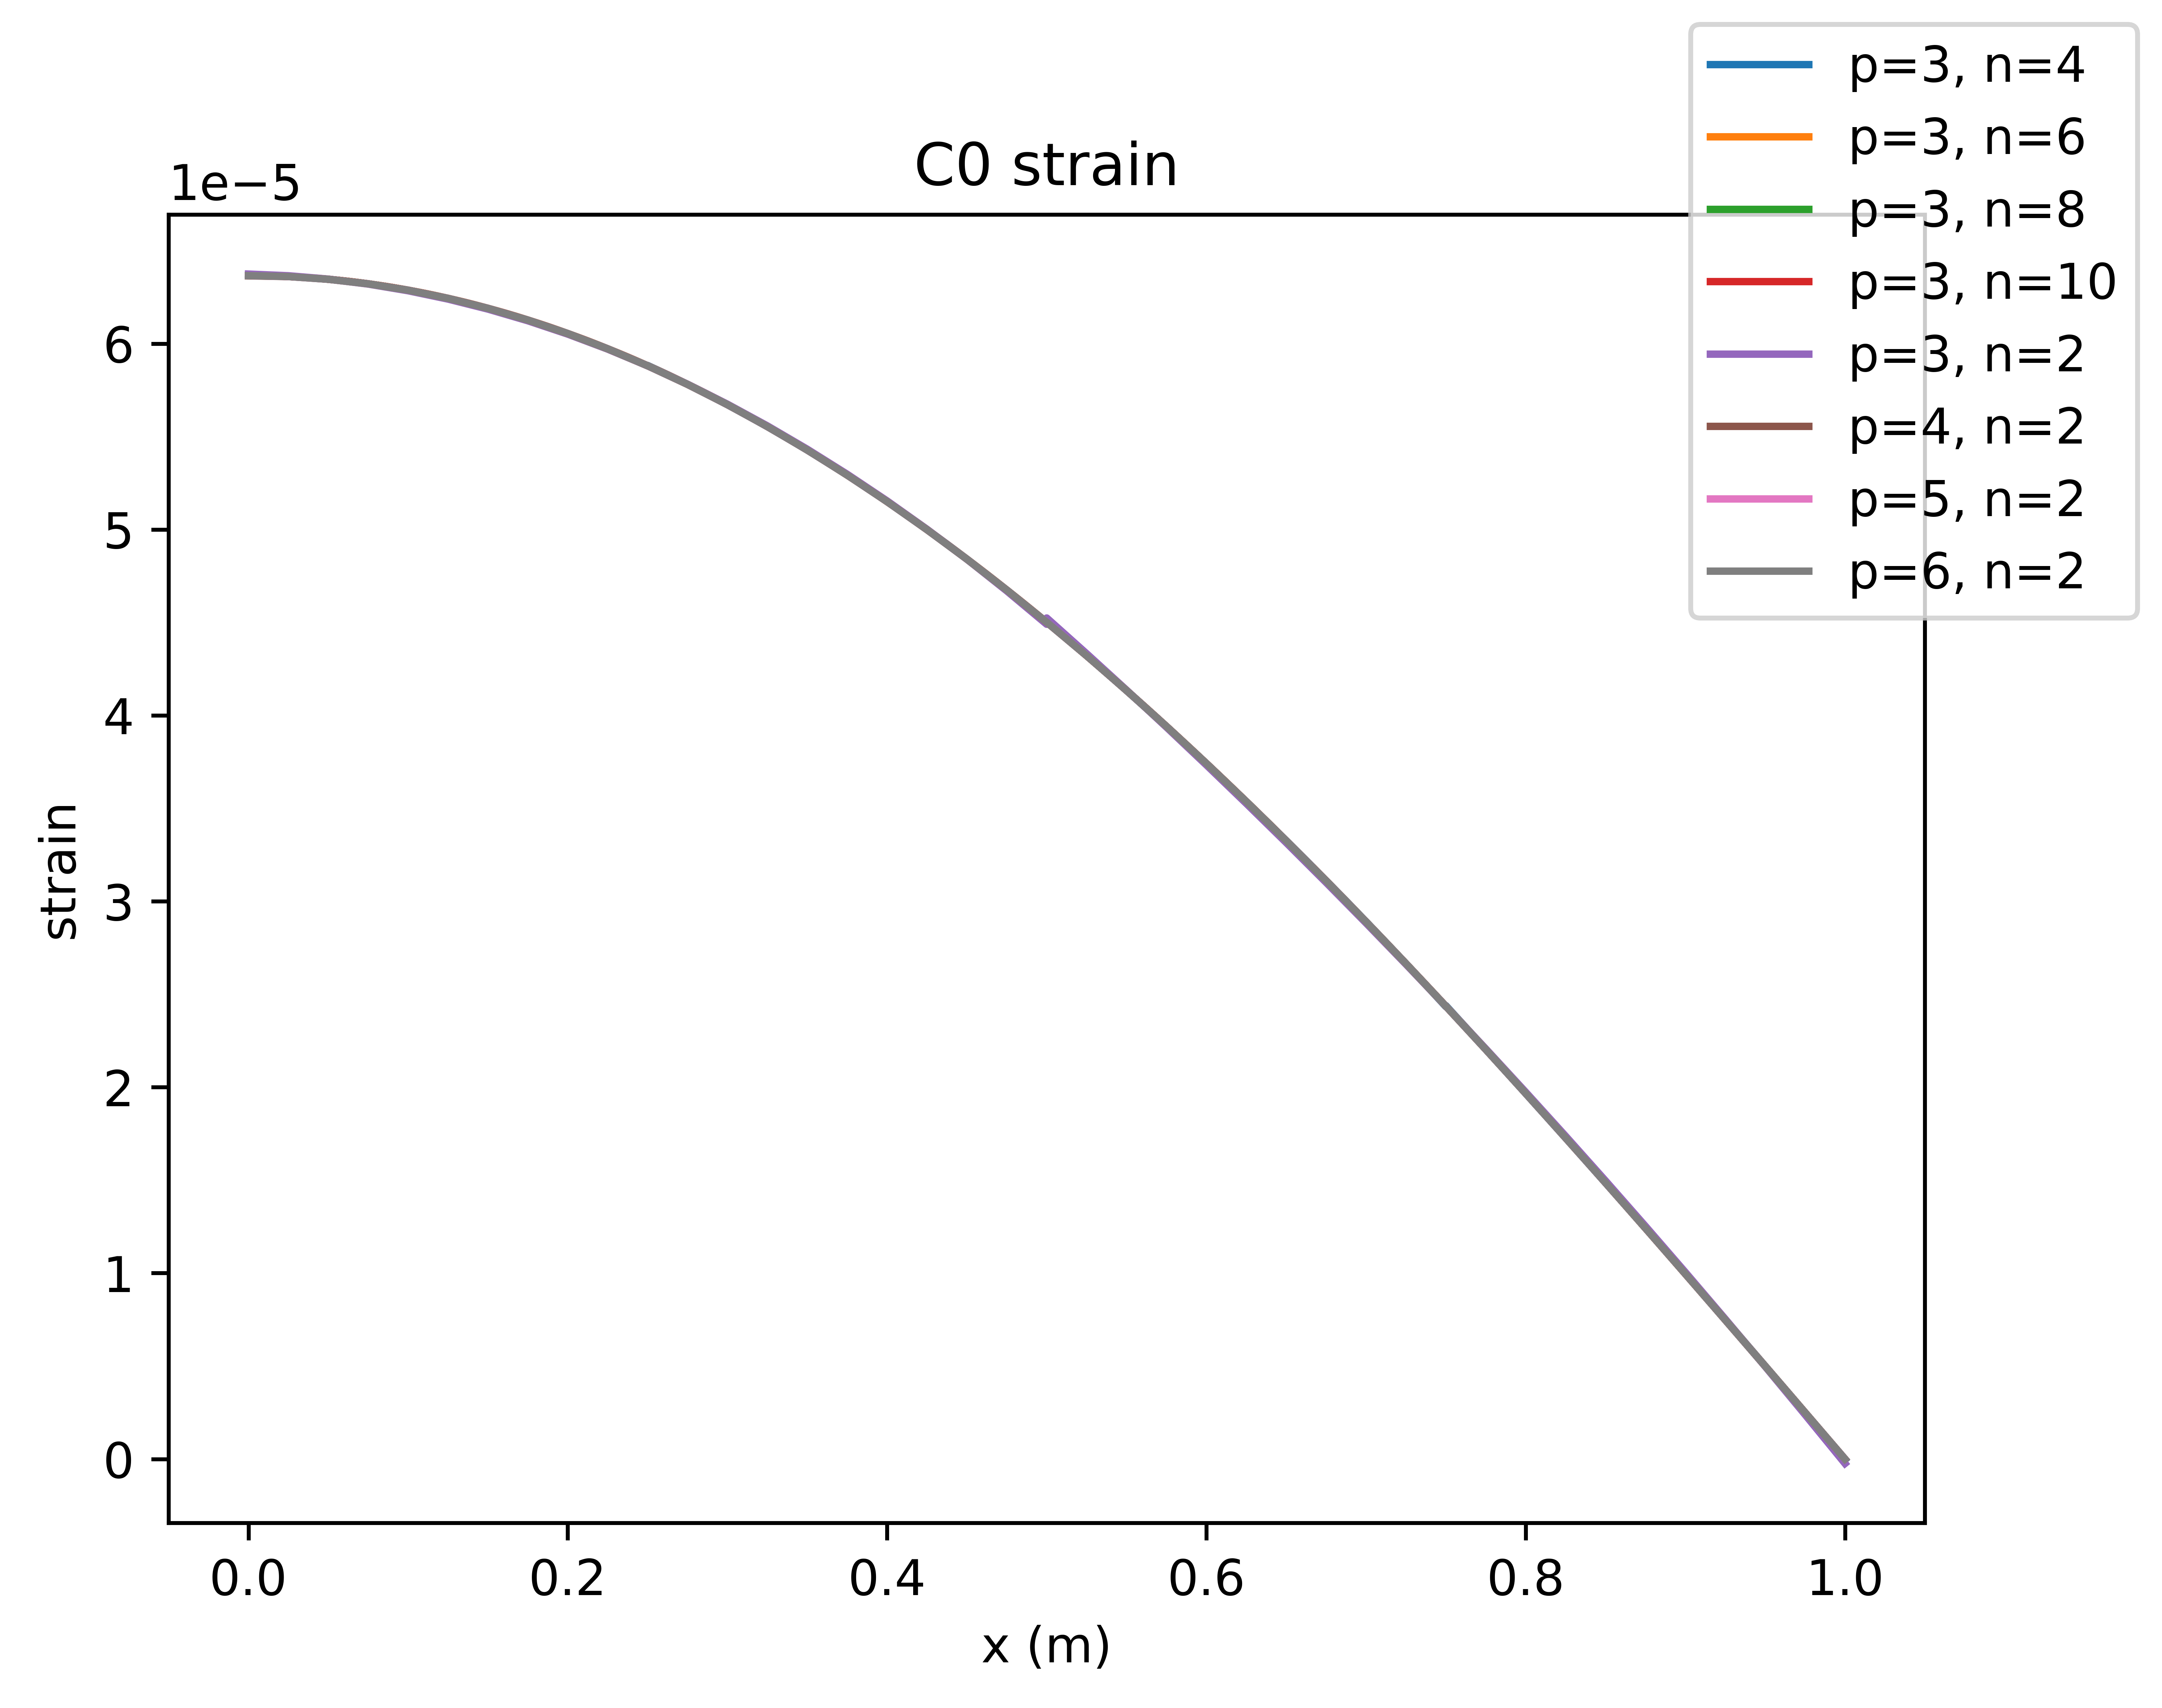

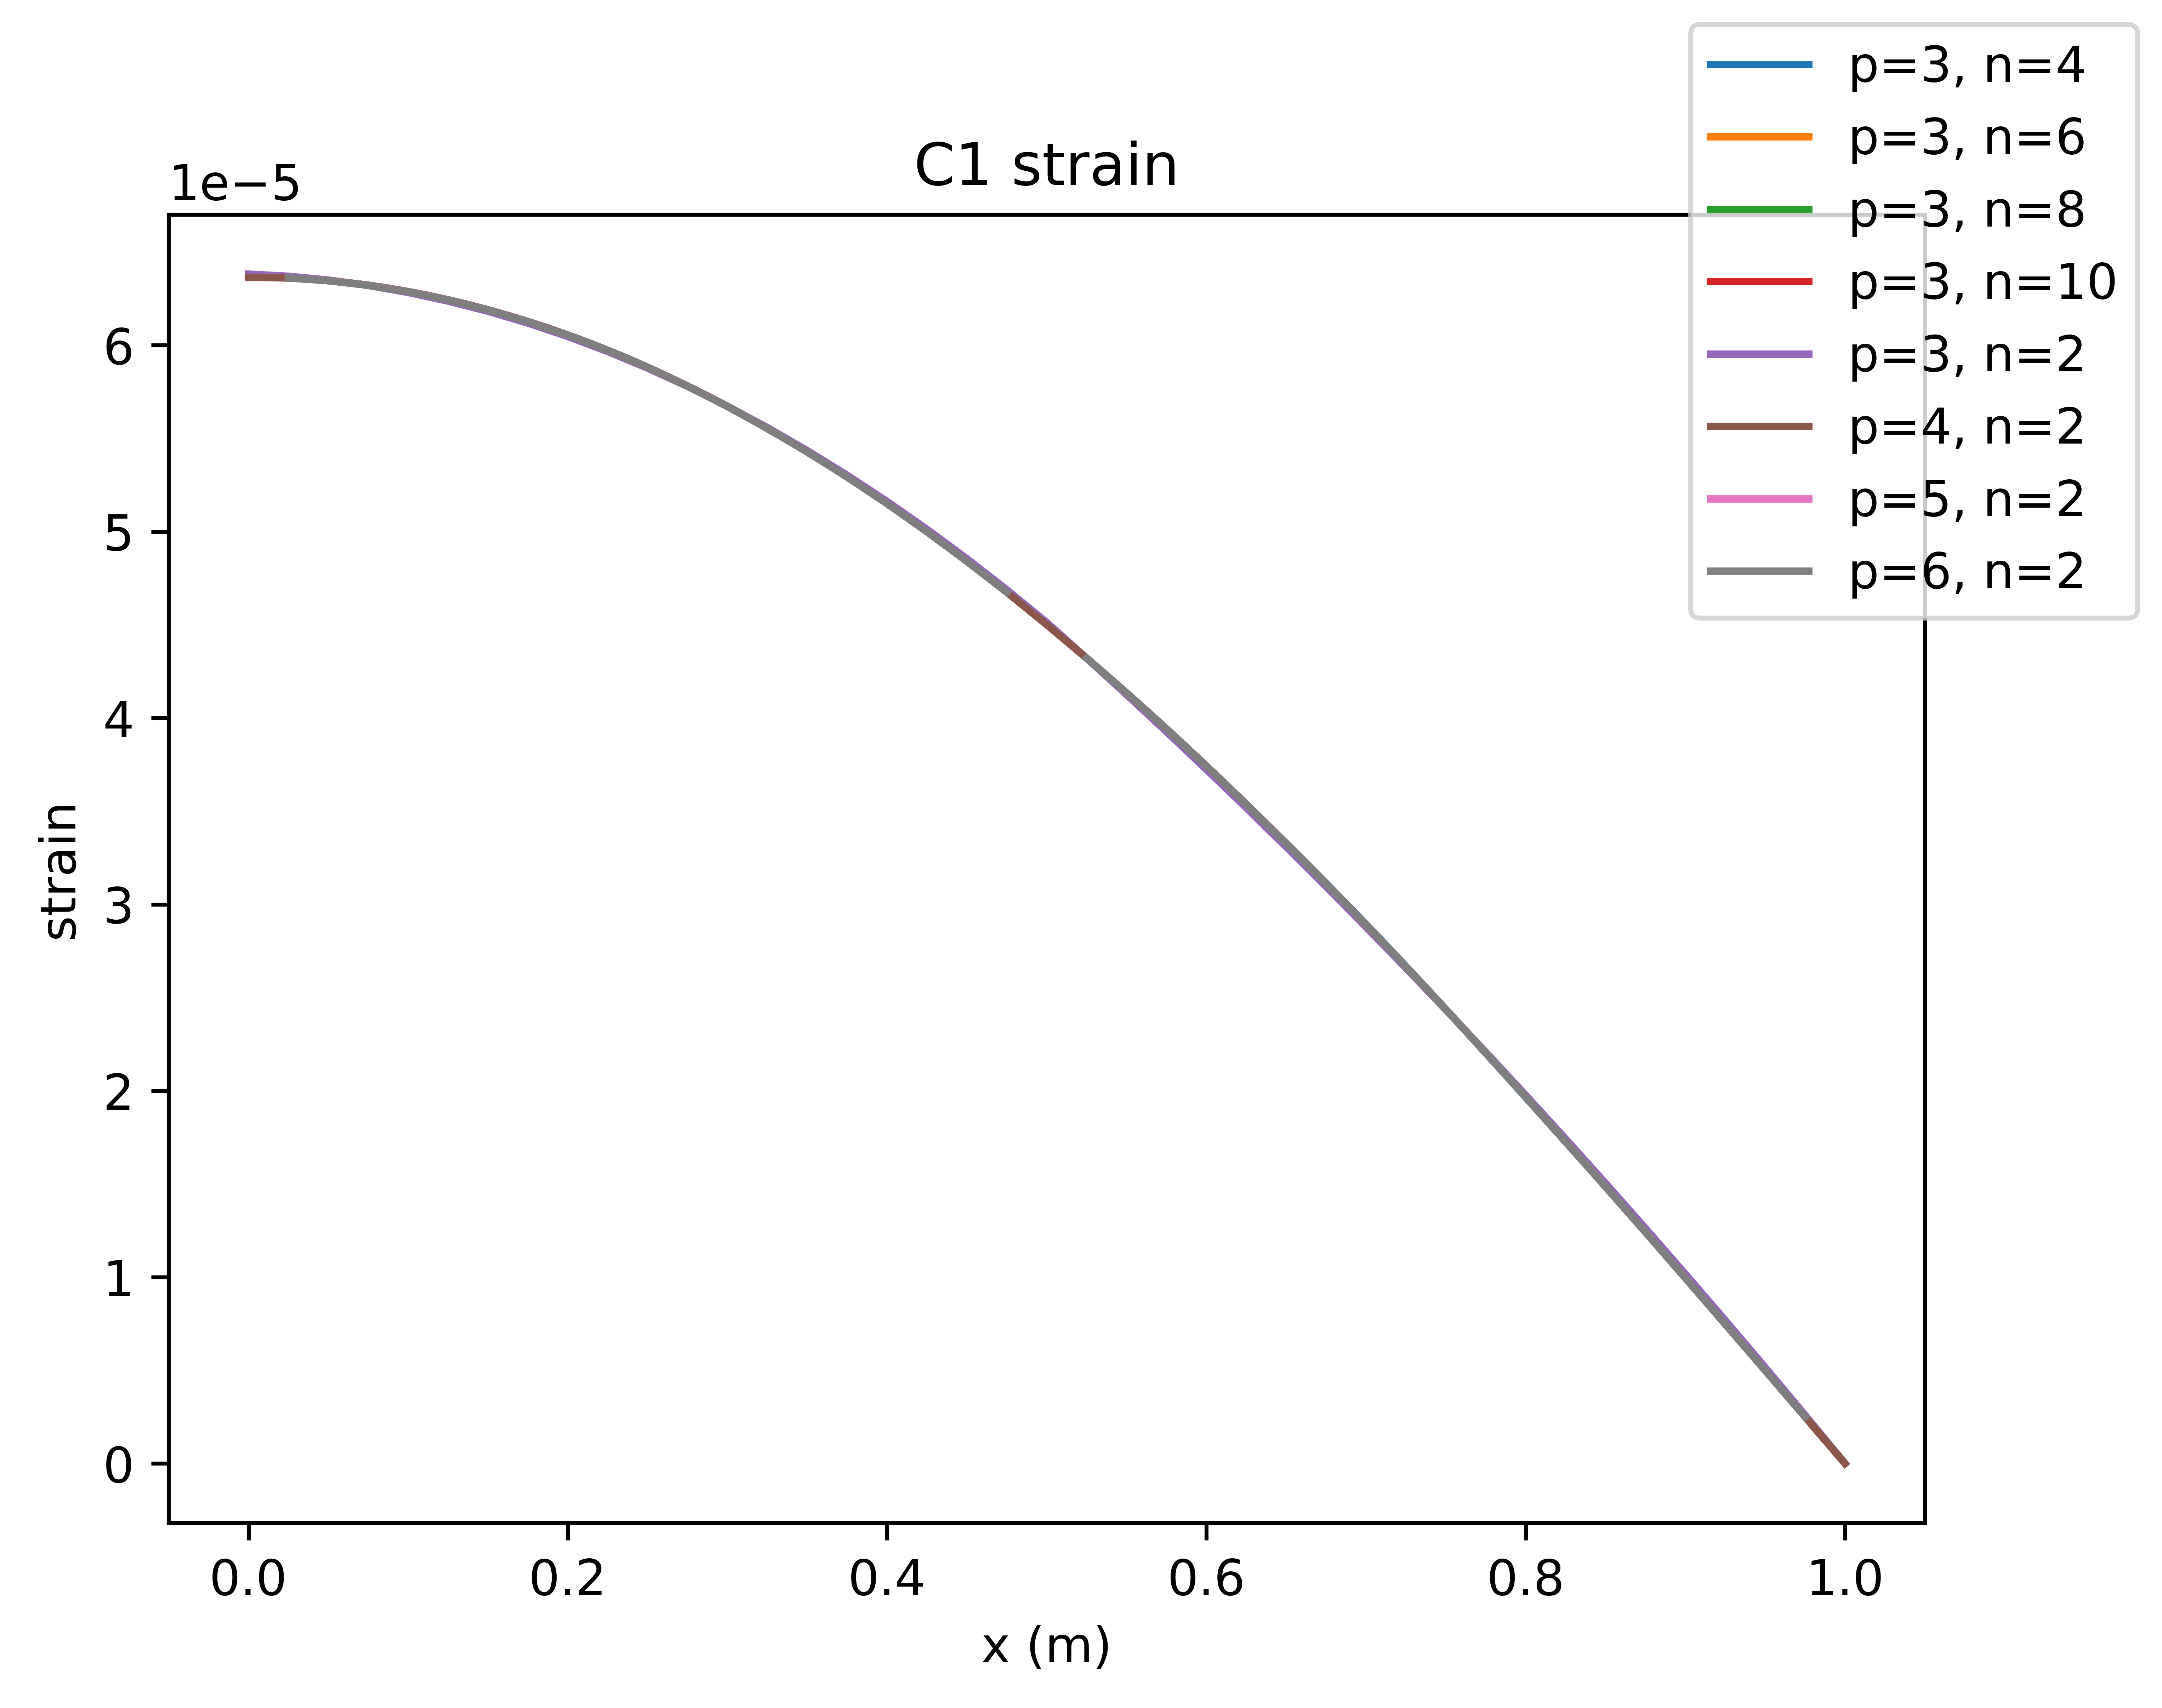

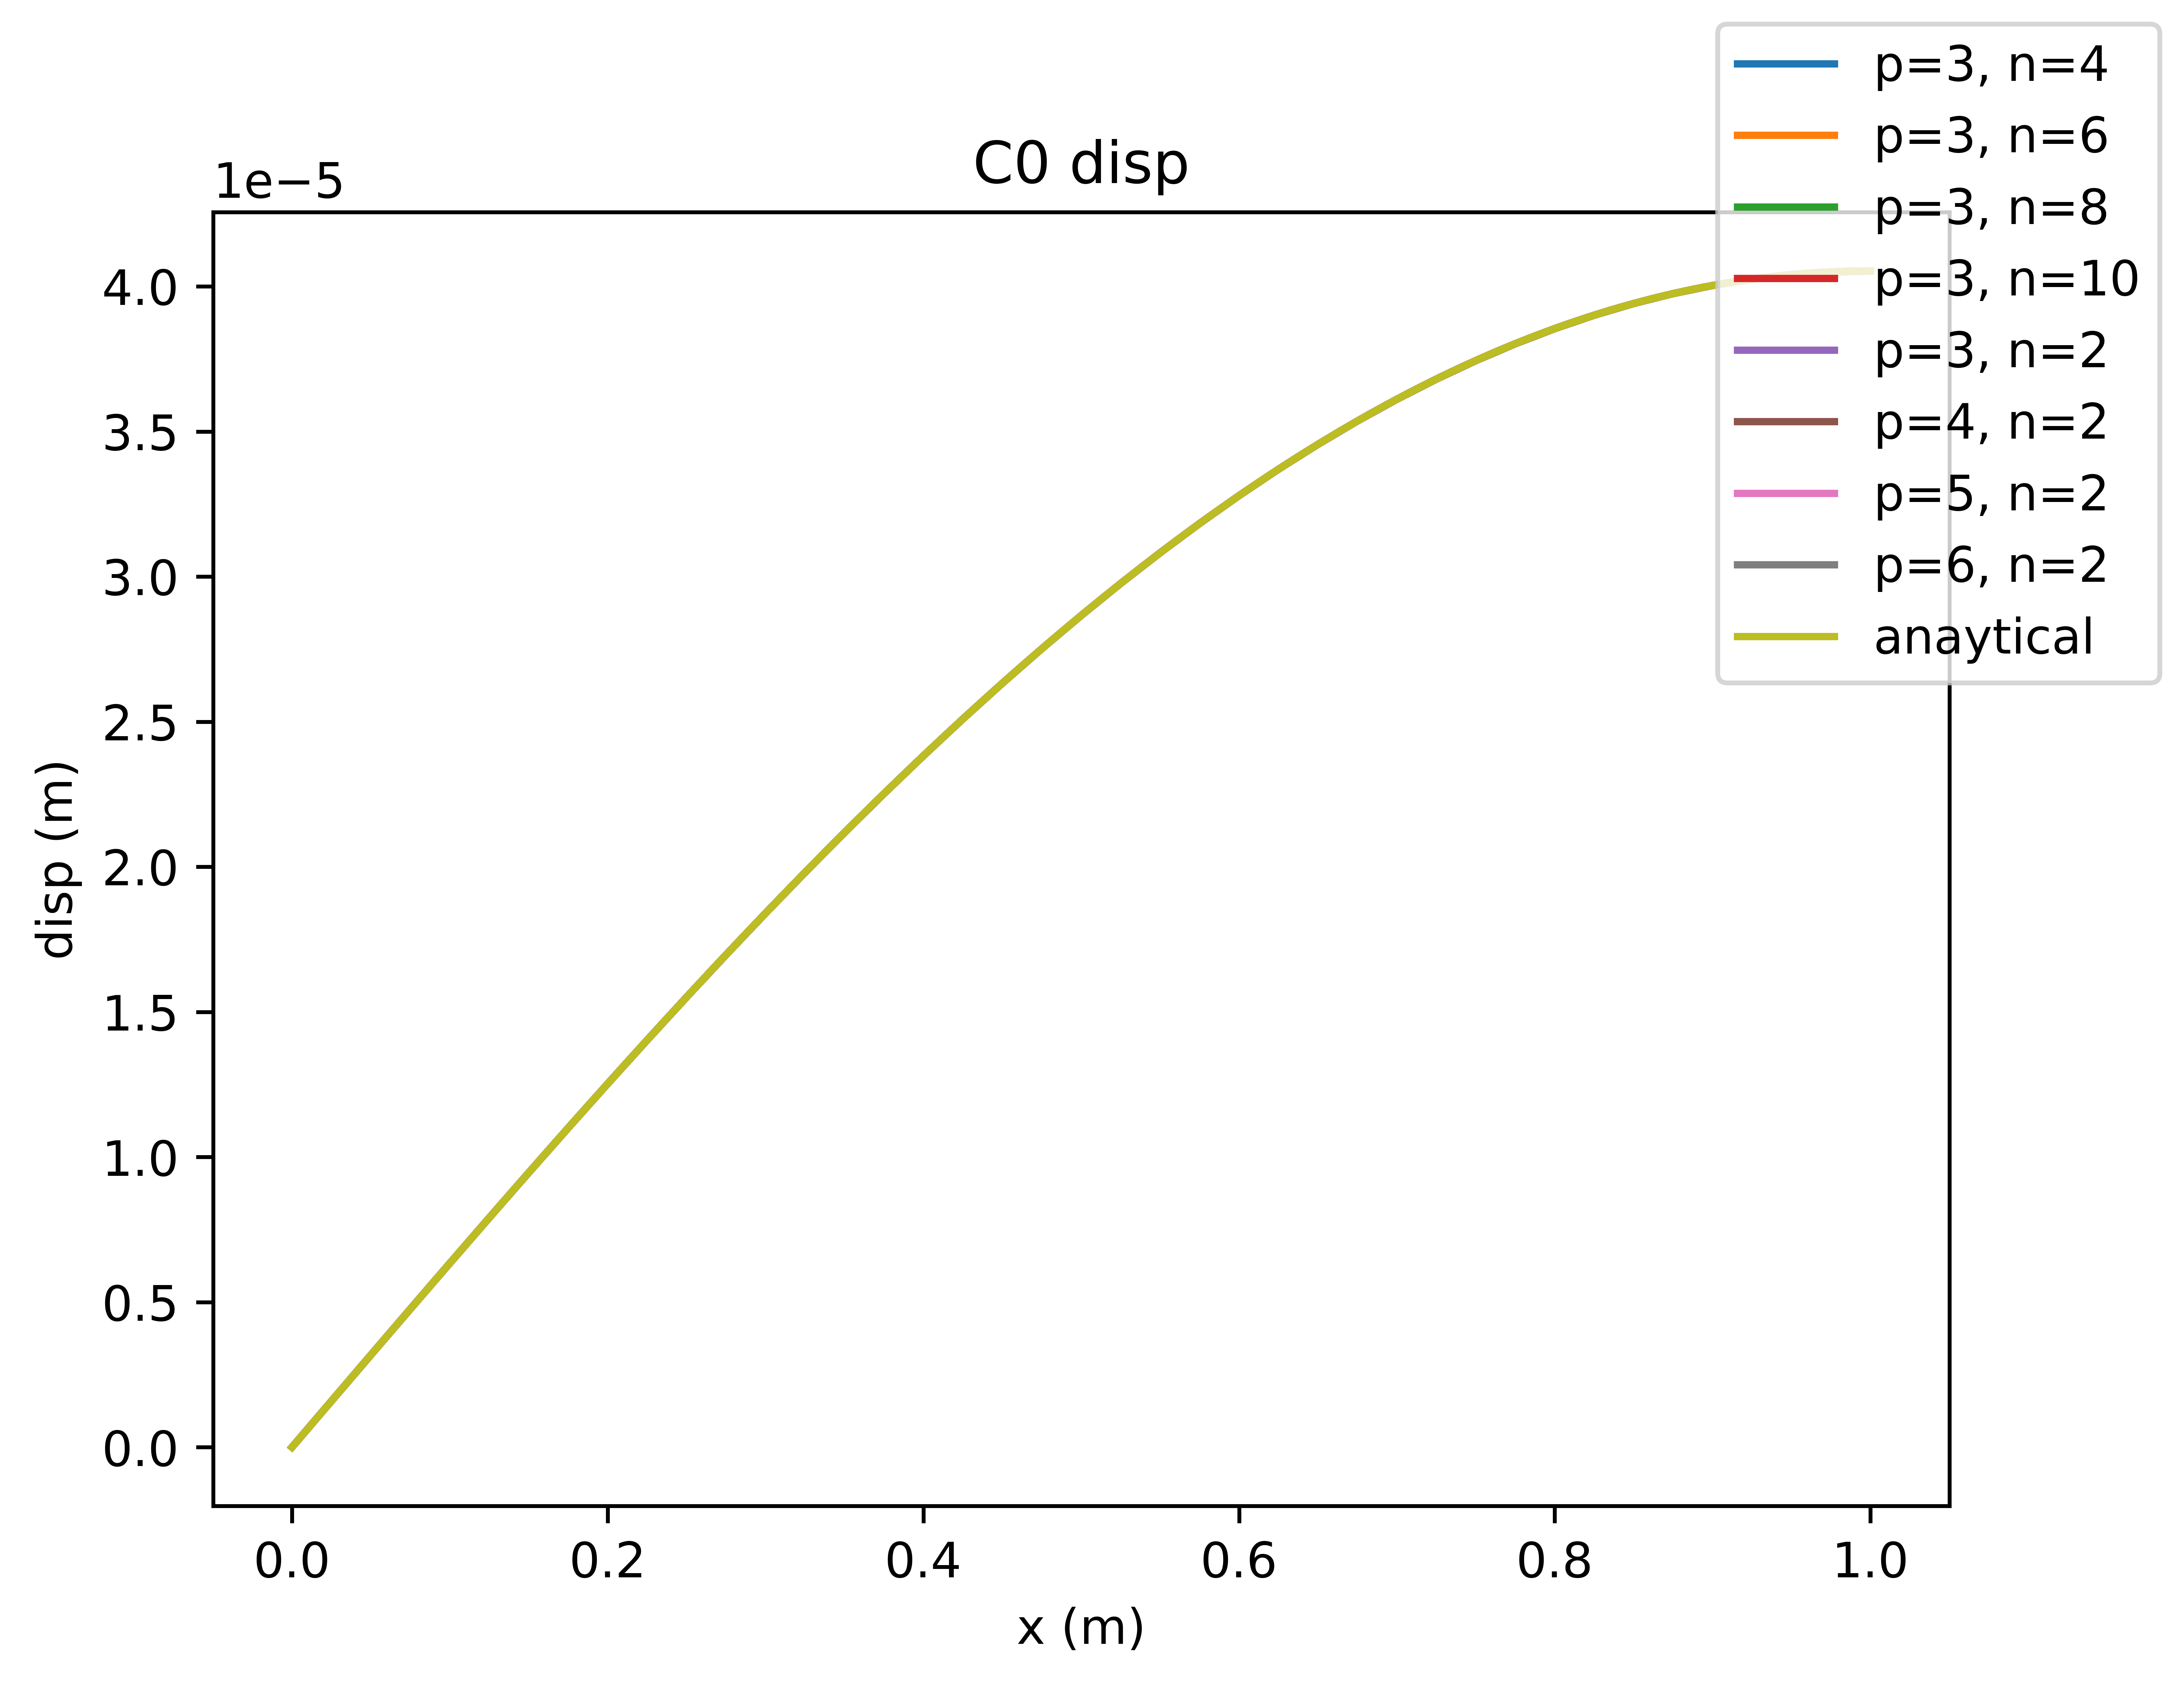

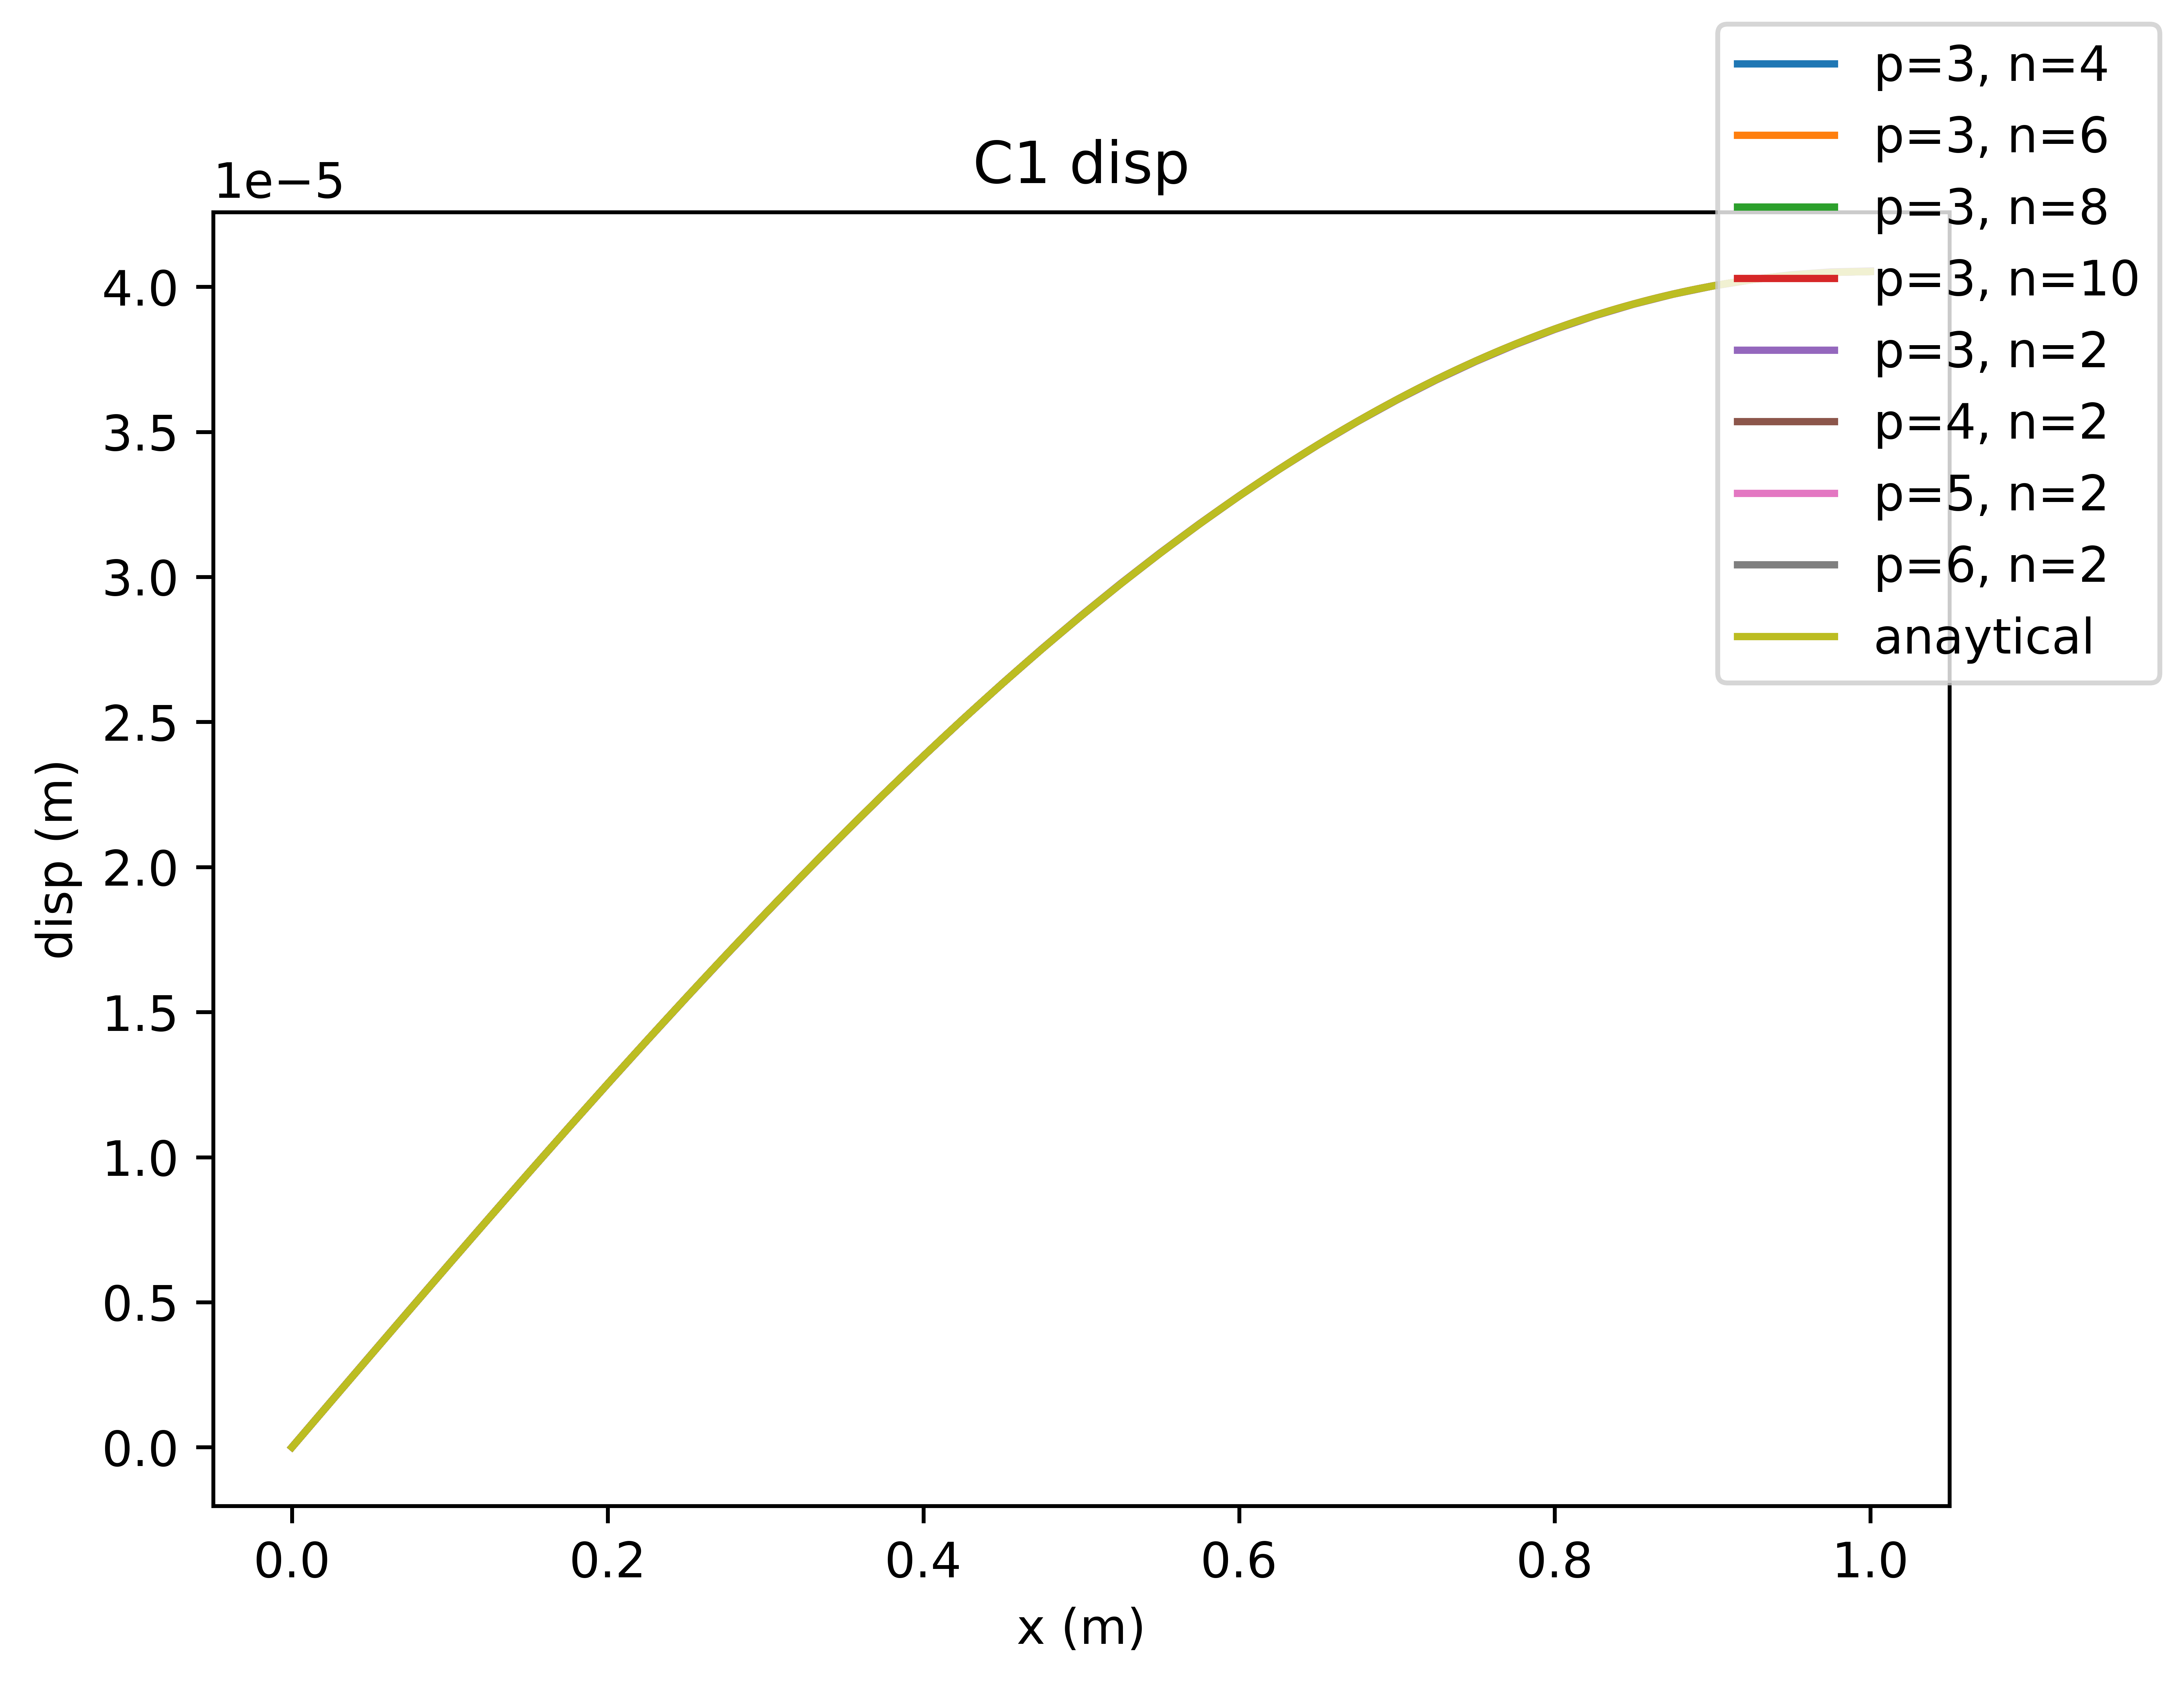

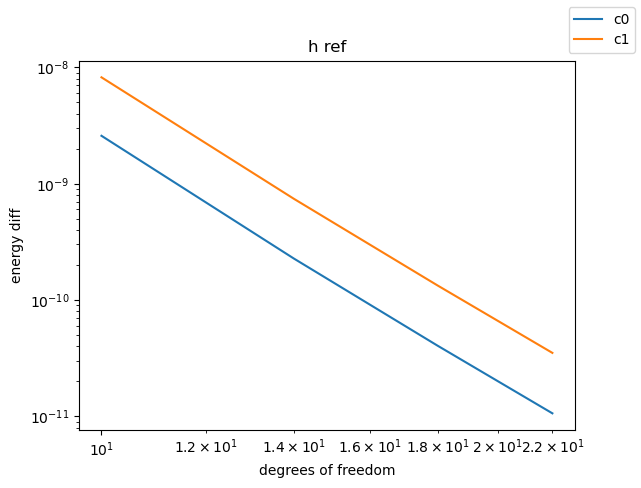

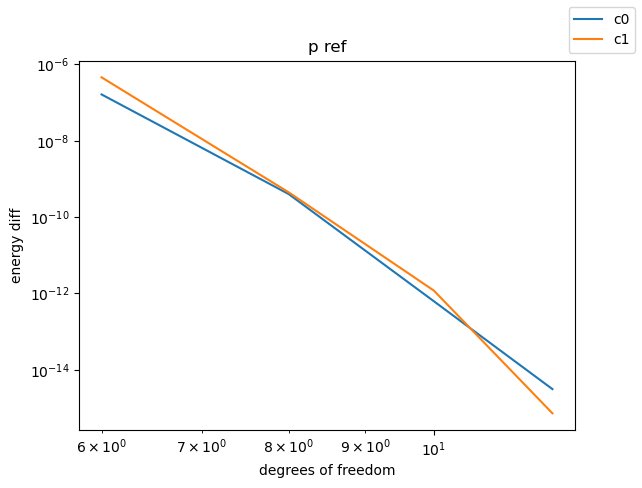

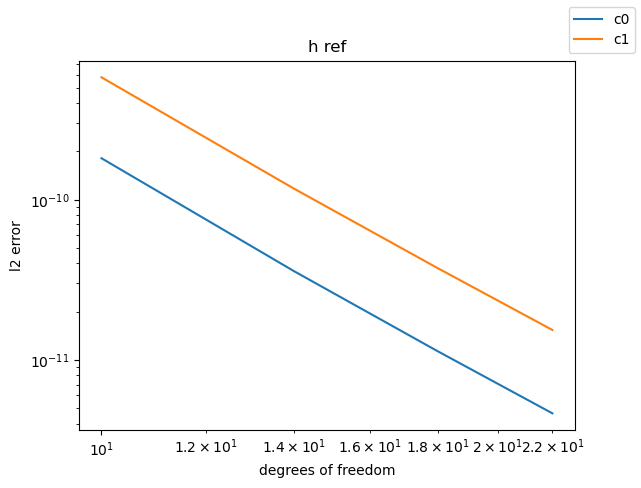

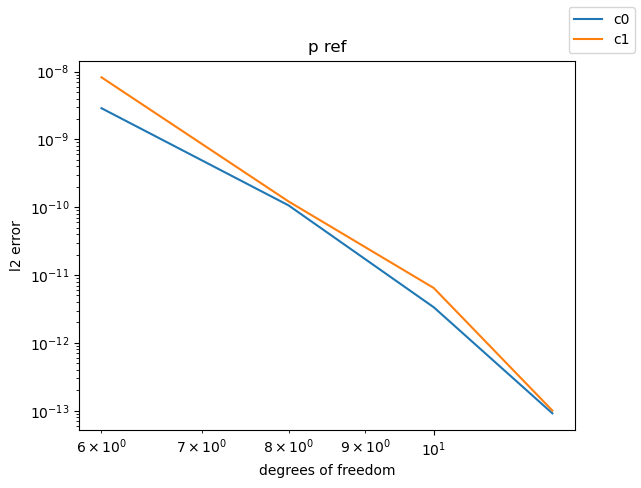

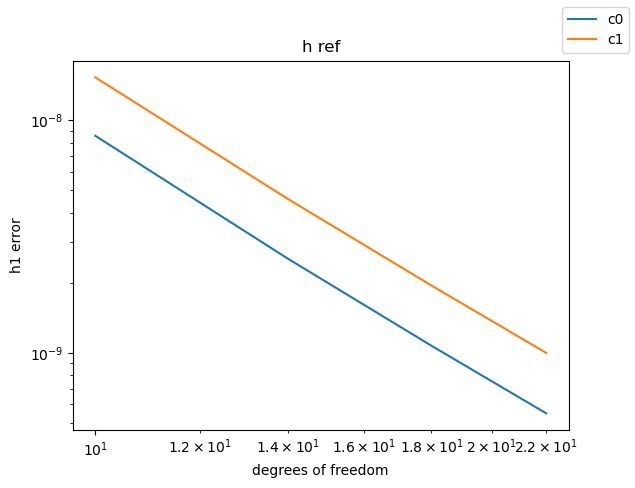

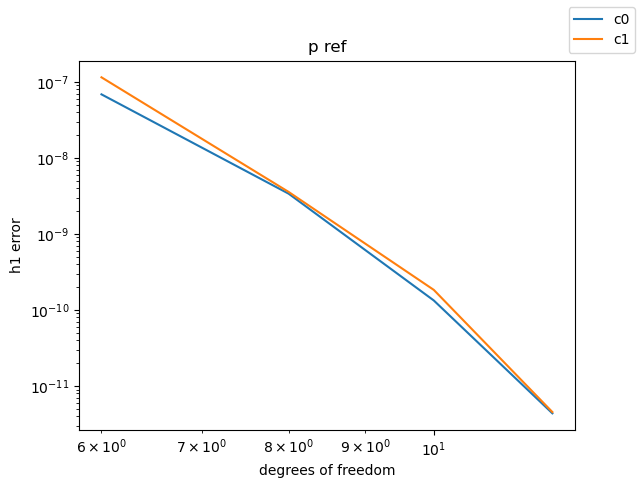

In [1]:
from dataclasses import replace
from functools import partial
import numpy as np
import numpy.typing as npt
import sympy as sy
import matplotlib.pyplot as plt
from bar_1d import BarInput
from c0_basis import (
    C0BarAnalysis,
    C0BarModel,
    calc_ecsi_placement_coords_gauss_lobato,
)
from c1_basis import C1BarAnalysis, C1BarModel
from nomeclature import NUM_DISPLACEMENT, X_COORD, NUM_STRAIN, ANALYTICAL_DISPLACEMENT
from statics import BarAnalysis

young_modulus = 100e9
section_area = 1.0e-4
length = 1.0
poly_degree = 1
n_elements = 2
x = sy.symbols("x")


def load_function(
    x: npt.NDArray[np.float64],
) -> npt.NDArray[np.float64]:
    return 1000 * np.sin(np.pi / 2 * x)


def displacement_analytical(x):
    return 4000 * np.sin(np.pi * x / 2) / (np.pi**2 * young_modulus * section_area)


def strain_analytical(x):
    return 2000 * np.cos(np.pi * x / 2) / (np.pi * young_modulus * section_area)


displacement_analytical_symb = (
    4000 * sy.sin(sy.pi * x / 2) / (sy.pi**2 * young_modulus * section_area)
)

analytical_energy = (
    sy.integrate(
        young_modulus * section_area * sy.diff(displacement_analytical_symb, x) ** 2,
        (x, 0, length),
    )
    ** 0.5
).evalf()

bar_input_h_study = BarInput(
    young_modulus=young_modulus,
    section_area=section_area,
    length=length,
    degree=3,
    n_elements=4,
    load_function=load_function,
)

bar_input_p_study = BarInput(
    young_modulus=young_modulus,
    section_area=section_area,
    length=length,
    degree=3,
    n_elements=2,
    load_function=load_function,
)


n_elements_cases = (4, 6, 8, 10)
degrees = (3, 4, 5, 6)

h_study_c0: dict[int, C0BarAnalysis] = dict()
p_study_c0: dict[int, C0BarAnalysis] = dict()
h_study_c1: dict[int, C1BarAnalysis] = dict()
p_study_c1: dict[int, C1BarAnalysis] = dict()

analysis = partial(
    BarAnalysis,
    displacement_analytical=displacement_analytical,
    displacement_derivative_analytical=strain_analytical,
)

analysis_c0 = partial(
    C0BarAnalysis,
    displacement_analytical=displacement_analytical,
    displacement_derivative_analytical=strain_analytical,
    ecsi_placement_coords_function=calc_ecsi_placement_coords_gauss_lobato,
)


analysis_c1 = partial(
    C1BarAnalysis,
    displacement_analytical=displacement_analytical,
    displacement_derivative_analytical=strain_analytical,
)

for n_elements in n_elements_cases:
    bar_input = replace(bar_input_h_study, n_elements=n_elements)
    c0_model = C0BarModel(
        inputs=bar_input,
        ecsi_placement_coords_function=calc_ecsi_placement_coords_gauss_lobato,
    )
    c1_model = C1BarModel(inputs=bar_input)
    h_study_c0[n_elements] = analysis(model=c0_model)
    h_study_c1[n_elements] = analysis(model=c1_model)


for degree in degrees:
    bar_input = replace(bar_input_p_study, degree=degree)
    c0_model = C0BarModel(
        inputs=bar_input,
        ecsi_placement_coords_function=calc_ecsi_placement_coords_gauss_lobato,
    )
    c1_model = C1BarModel(inputs=bar_input)
    p_study_c0[degree] = analysis(model=c0_model)
    p_study_c1[degree] = analysis(model=c1_model)


degrees_freedom_h = tuple(
    case.bar_result.n_degrees_freedom for case in h_study_c1.values()
)
l2_error_h_c0 = tuple(case.l2_error for case in h_study_c0.values())
l2_error_h_c1 = tuple(case.l2_error for case in h_study_c1.values())
energy_diff_h_c0 = tuple(
    analytical_energy - case.energy_norm_aprox_sol for case in h_study_c0.values()
)
energy_diff_h_c1 = tuple(
    analytical_energy - case.energy_norm_aprox_sol for case in h_study_c1.values()
)
h1_error_h_c0 = tuple(case.h1_error for case in h_study_c0.values())
h1_error_h_c1 = tuple(case.h1_error for case in h_study_c1.values())


degrees_freedom_p = tuple(
    case.bar_result.n_degrees_freedom for case in p_study_c1.values()
)
l2_error_p_c0 = tuple(case.l2_error for case in p_study_c0.values())
l2_error_p_c1 = tuple(case.l2_error for case in p_study_c1.values())


energy_diff_p_c0 = tuple(
    analytical_energy - case.energy_norm_aprox_sol for case in p_study_c0.values()
)
energy_diff_p_c1 = tuple(
    analytical_energy - case.energy_norm_aprox_sol for case in p_study_c1.values()
)

h1_error_p_c0 = tuple(case.h1_error for case in p_study_c0.values())
h1_error_p_c1 = tuple(case.h1_error for case in p_study_c1.values())


dfs = [
    (
        case.results,
        case.model.inputs.degree,
        case.model.inputs.n_elements,
    )
    for case in h_study_c0.values()
]

dfs += [
    (
        case.results,
        case.model.inputs.degree,
        case.model.inputs.n_elements,
    )
    for case in p_study_c0.values()
]


dfs_c1 = [
    (
        case.results,
        case.model.inputs.degree,
        case.model.inputs.n_elements,
    )
    for case in h_study_c1.values()
]

dfs_c1 += [
    (
        case.results,
        case.model.inputs.degree,
        case.model.inputs.n_elements,
    )
    for case in p_study_c1.values()
]


def plot_result(ax, result_df, key: str, name: str = "disp"):
    ax.plot(result_df[X_COORD], result_df[key], label=name)


def plot_results(ax, result_dfs, key: str, name: str = "disp"):
    for i, r in enumerate(result_dfs):
        plot_result(ax, r, key, f"{name} {i+2}")


ax_strain: plt.Axes

fig_strain, ax_strain = plt.subplots()
ax_strain.set_xlabel("x (m)")
ax_strain.set_ylabel("strain")
ax_strain.set_title("C0 strain")
for df, degree, n in dfs:
    plot_result(ax=ax_strain, result_df=df, key=NUM_STRAIN, name=f"p={degree}, n={n}")

# plot_result(
#     ax=ax_disp, result_df=dfs[0][0], key=ANALYTICAL_DISPLACEMENT, name=f"anaytical"
# )

fig_strain.legend()
fig_strain.set_dpi(1000)


ax_strain2: plt.Axes

fig_strain2, ax_strain2 = plt.subplots()
ax_strain2.set_xlabel("x (m)")
ax_strain2.set_ylabel("strain")
ax_strain2.set_title("C1 strain")
for df, degree, n in dfs_c1:
    plot_result(ax=ax_strain2, result_df=df, key=NUM_STRAIN, name=f"p={degree}, n={n}")

# plot_result(
#     ax=ax_disp2, result_df=dfs[0][0], key=ANALYTICAL_DISPLACEMENT, name=f"anaytical"
# )

fig_strain2.legend()
fig_strain2.set_dpi(1000)


ax_disp: plt.Axes

fig_dips, ax_disp = plt.subplots()
ax_disp.set_xlabel("x (m)")
ax_disp.set_ylabel("disp (m)")
ax_disp.set_title("C0 disp")
for df, degree, n in dfs:
    plot_result(
        ax=ax_disp, result_df=df, key=NUM_DISPLACEMENT, name=f"p={degree}, n={n}"
    )

plot_result(
    ax=ax_disp, result_df=dfs[0][0], key=ANALYTICAL_DISPLACEMENT, name="anaytical"
)

fig_dips.legend()
fig_dips.set_dpi(1000)


ax_disp2: plt.Axes

fig_dips2, ax_disp2 = plt.subplots()
ax_disp2.set_xlabel("x (m)")
ax_disp2.set_ylabel("disp (m)")
ax_disp2.set_title("C1 disp")
for df, degree, n in dfs_c1:
    plot_result(
        ax=ax_disp2, result_df=df, key=NUM_DISPLACEMENT, name=f"p={degree}, n={n}"
    )

plot_result(
    ax=ax_disp2, result_df=dfs[0][0], key=ANALYTICAL_DISPLACEMENT, name="anaytical"
)

fig_dips2.legend()
fig_dips2.set_dpi(1000)


ax: plt.Axes
fig, ax = plt.subplots()
ax.set_title("h ref")
ax.set_xlabel("degrees of freedom")
ax.set_ylabel("energy diff")
ax.loglog(degrees_freedom_h, energy_diff_h_c0, label="c0")
ax.loglog(degrees_freedom_h, energy_diff_h_c1, label="c1")
fig.legend()

ax2: plt.Axes
fig2, ax2 = plt.subplots()
ax2.set_title("p ref")
ax2.set_xlabel("degrees of freedom")
ax2.set_ylabel("energy diff")
ax2.loglog(degrees_freedom_p, energy_diff_p_c0, label="c0")
ax2.loglog(degrees_freedom_p, energy_diff_p_c1, label="c1")
fig2.legend()

ax3: plt.Axes
fig3, ax3 = plt.subplots()
ax3.set_title("h ref")
ax3.set_xlabel("degrees of freedom")
ax3.set_ylabel("l2 error")
ax3.loglog(degrees_freedom_h, l2_error_h_c0, label="c0")
ax3.loglog(degrees_freedom_h, l2_error_h_c1, label="c1")
fig3.legend()

ax4: plt.Axes
fig4, ax4 = plt.subplots()
ax4.set_title("p ref")
ax4.set_xlabel("degrees of freedom")
ax4.set_ylabel("l2 error")
ax4.loglog(degrees_freedom_p, l2_error_p_c0, label="c0")
ax4.loglog(degrees_freedom_p, l2_error_p_c1, label="c1")
fig4.legend()


ax5: plt.Axes
fig5, ax5 = plt.subplots()
ax5.set_title("h ref")
ax5.set_xlabel("degrees of freedom")
ax5.set_ylabel("h1 error")
ax5.loglog(degrees_freedom_h, h1_error_h_c0, label="c0")
ax5.loglog(degrees_freedom_h, h1_error_h_c1, label="c1")
fig5.legend()

ax6: plt.Axes
fig6, ax6 = plt.subplots()
ax6.set_title("p ref")
ax6.set_xlabel("degrees of freedom")
ax6.set_ylabel("h1 error")
ax6.loglog(degrees_freedom_p, h1_error_p_c0, label="c0")
ax6.loglog(degrees_freedom_p, h1_error_p_c1, label="c1")
fig6.legend()